In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from datetime import datetime
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

from sklearn.ensemble import IsolationForest
from pyod.models.knn import KNN 

# description of data

#### Loan_data
In table Loan_data there is information about short term loans (term is shorter than 5 months) that
were issued from July 2022:
- Loan_id,
- Client_id,
- Start_date – date when loan started,
- Loan_amount – actual principal amount issued,
- Due_date – date when loan needs to be repaid,
- Loan status – status of a loan as at today, 5 – means loan is paid, 4 – means loan is not paid.
- Scoring_score – risk score at the moment of application.
#### Client_data
In table Client_data there is information of a client at the moment of registration:
- Client_id,
- Birthday,
- Gender,
- Monthly salary – income that client fills in.
#### Payment_data
In table Payment_data there is information about loan repayments:
- Loan_id,
- Payment_date – date of a payment,
- Paid_principal – this payment’s principal part,
- Paid_fines – this payment’s fines part,
- Paid_other - this payment’s part that is not principal and not fines (all the loan related fees).

In [2]:
df_client = pd.read_csv('./data/client_data_202311041924.csv')

In [3]:
df_loan = pd.read_csv('./data/loan_data_202311041924.csv')

In [4]:
df_payment = pd.read_csv('./data/payment_data_202311041924.csv')

# primary analysis

## customer data

In [5]:
df_client.head()

,client_id,birthday,gender,monthly_salary
0,220479,1954-03-13,m,62000.0
1,185677,1980-09-12,m,93000.0
2,143901,1961-03-21,m,93000.0
3,185704,1968-07-20,f,51000.0
4,78686,1981-12-29,f,59000.0


In [6]:
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49118 entries, 0 to 49117
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       49118 non-null  int64  
 1   birthday        49114 non-null  object 
 2   gender          49111 non-null  object 
 3   monthly_salary  49116 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [83]:
print(df_client['client_id'].nunique())

49118


Gaps in data
- birthday 4 meanings
- monthly_salary 2 values

In [7]:
for col in ['birthday','monthly_salary']:
    display(df_client.loc[df_client[col].isnull()])

,client_id,birthday,gender,monthly_salary
10725,68840,NaN,f,66000.0
10754,46251,NaN,f,76000.0
21678,226080,NaN,m,86000.0
29748,213791,NaN,m,59000.0


,client_id,birthday,gender,monthly_salary
30044,195448,1962-12-25,f,NaN
30093,181721,1997-03-27,f,NaN


In [8]:
# update data types
df_client['birthday'] = pd.to_datetime(df_client['birthday'], format='%Y-%m-%d')

In [9]:
# creating new features
today = '2023-11-04'
df_client['age'] = (datetime.strptime(today, '%Y-%m-%d') - df_client["birthday"]).dt.days/365.25
df_client['gender'] = np.where(df_client['gender']=='m',1,0)

In [10]:
df_client.describe()

,client_id,gender,monthly_salary,age
count,49118.000000,49118.000000,49116.000000,49114.000000
mean,160116.823059,0.619793,74956.470397,36.873392
std,61794.605421,0.485442,14599.333066,12.988482
min,5406.000000,0.000000,50000.000000,20.019165
25%,120250.000000,0.000000,62000.000000,25.823409
50%,186897.500000,1.000000,75000.000000,33.557837
75%,207222.500000,1.000000,87000.000000,45.618070
max,229360.000000,1.000000,530000.000000,72.700890


In [11]:
r_wisker = df_client['monthly_salary'].quantile(0.75) + 3 * (df_client['monthly_salary'].quantile(0.75) - df_client['monthly_salary'].quantile(0.25))
df_client.loc[df_client['monthly_salary']>r_wisker]

,client_id,birthday,gender,monthly_salary,age
30132,66525,1996-01-25,0,530000.0,27.775496


- gender data looks adequate
- monthly_salary data has a standard distribution, with one client being singled out with an abnormally large monthly_salary amount. Possibly an error in filling out the application.
- age data has a standard distribution

`for client 66525, an additional zero was presumably added to the application, we will correct and remember the client`

In [12]:
df_client['monthly_salary'] = np.where(df_client['monthly_salary']>r_wisker, 
                                       df_client['monthly_salary']/10,
                                       df_client['monthly_salary'])

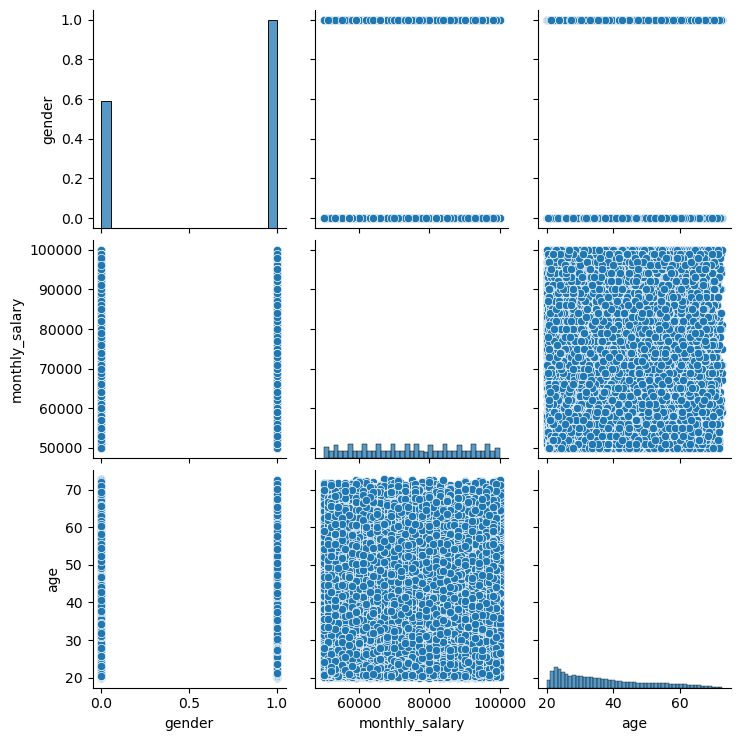

In [13]:
sns.pairplot(df_client.drop('client_id', axis=1) , diag_kind='hist')

## loan data

In [14]:
df_loan.head()

,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score
0,437612,5406,2023-07-01,35000,2023-07-31,5,517.64
1,442800,5406,2023-07-24,20000,2023-08-23,5,544.69
2,446334,5406,2023-08-08,45000,2023-09-07,5,653.92
3,455642,5406,2023-09-19,55000,2023-10-19,5,604.93
4,357393,5453,2022-07-26,60000,2022-08-25,5,619.72


In [15]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61719 entries, 0 to 61718
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   loan_id        61719 non-null  int64  
 1   client_id      61719 non-null  int64  
 2   start_date     61719 non-null  object 
 3   loan_amount    61719 non-null  int64  
 4   due_date       61719 non-null  object 
 5   loan_status    61719 non-null  int64  
 6   scoring_score  61712 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 3.3+ MB


In [82]:
print(df_loan['loan_id'].nunique())

61719


there are gaps in the data for scoring_score 7 values

In [16]:
df_loan.loc[df_loan['scoring_score'].isnull()]

,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score
27441,435091,161437,2023-06-20,70000,2023-07-20,5,NaN
27481,442029,161618,2023-07-22,55000,2023-08-21,4,NaN
37176,356380,193966,2022-07-21,20000,2022-08-20,5,NaN
37235,405325,194118,2023-02-14,30000,2023-03-16,5,NaN
37340,434165,194361,2023-06-16,50000,2023-07-16,5,NaN
37409,377151,194554,2022-10-19,10000,2022-11-18,5,NaN
37453,457901,194698,2023-10-03,30000,2023-11-02,4,NaN


In [17]:
# update data types
df_loan['start_date'] = pd.to_datetime(df_loan['start_date'], format='%Y-%m-%d')
df_loan['due_date'] = pd.to_datetime(df_loan['due_date'], format='%Y-%m-%d')

In [18]:
# let's create new features
df_loan['fl_debt'] = np.where(df_loan['loan_status']==4, 1,0)
df_loan['duration'] = (df_loan["due_date"] - df_loan["start_date"]).dt.days/30

In [119]:
# check the condition - Clients cannot take multiple short-term loans at the same time

In [20]:
table = pd.pivot_table(df_loan.loc[(df_loan['loan_status']==4) & (df_loan['duration']<=1)],
                       index='client_id',
                       values='loan_id',
                       aggfunc='count').reset_index()                       

In [21]:
client_error = table[(table['loan_id']>1)]['client_id'].unique().tolist()

In [22]:
for cli in client_error:
    display(df_loan.loc[(df_loan['client_id'].isin([cli])) & (df_loan['loan_status']==4)])

,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score,fl_debt,duration
4724,458235,35118,2023-09-29,40000,2023-10-29,4,625.72,1,1.0
4725,464868,35118,2023-10-28,30000,2023-11-27,4,625.72,1,1.0


,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score,fl_debt,duration
28387,451479,165208,2023-08-31,70000,2023-09-30,4,561.25,1,1.0
28388,458661,165208,2023-10-02,70000,2023-11-01,4,561.25,1,1.0


,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score,fl_debt,duration
38813,355683,198122,2022-07-19,25000,2022-08-18,4,404.27,1,1.0
38814,428744,198122,2023-05-24,25000,2023-06-23,4,270.71,1,1.0


,loan_id,client_id,start_date,loan_amount,due_date,loan_status,scoring_score,fl_debt,duration
49964,412991,211759,2023-03-17,10000,2023-04-16,4,459.40,1,1.0
49965,412993,211759,2023-03-17,10000,2023-04-16,4,427.27,1,1.0


In [23]:
df_loan.describe()

,loan_id,client_id,loan_amount,loan_status,scoring_score,fl_debt,duration
count,61719.000000,61719.000000,61719.000000,61719.000000,61712.000000,61719.000000,61719.000000
mean,407387.092111,150535.587858,32927.688394,4.788201,491.599962,0.211799,1.741686
std,32868.153885,66450.884398,17603.240060,0.408586,118.297668,0.408586,1.122548
min,351837.000000,5406.000000,4000.000000,4.000000,72.950000,0.000000,0.033333
25%,378839.500000,96128.000000,20000.000000,5.000000,405.040000,0.000000,1.000000
50%,406564.000000,173918.000000,30000.000000,5.000000,495.680000,0.000000,1.000000
75%,435639.000000,207084.500000,45000.000000,5.000000,577.990000,0.000000,2.033333
max,465523.000000,229257.000000,140000.000000,5.000000,825.770000,1.000000,7.000000


<Axes: >

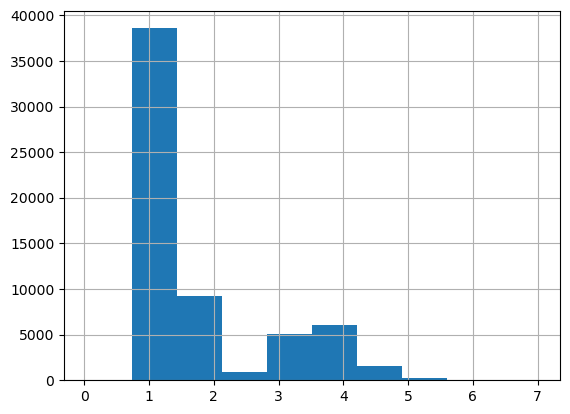

In [24]:
df_loan['duration'].hist()

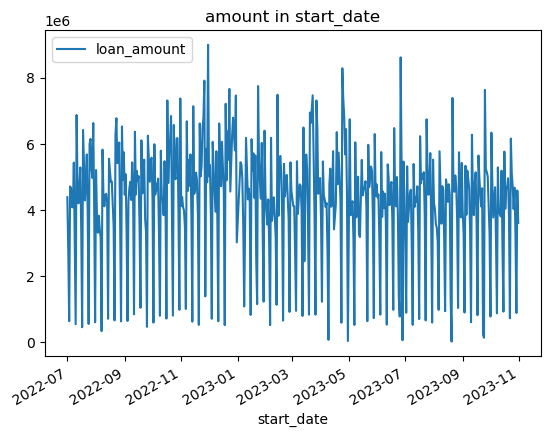

In [122]:
loan_amount = pd.pivot_table(df_loan,
                               index='start_date',
                               values='loan_amount',
                               aggfunc=np.sum).plot(title='amount in start_date')

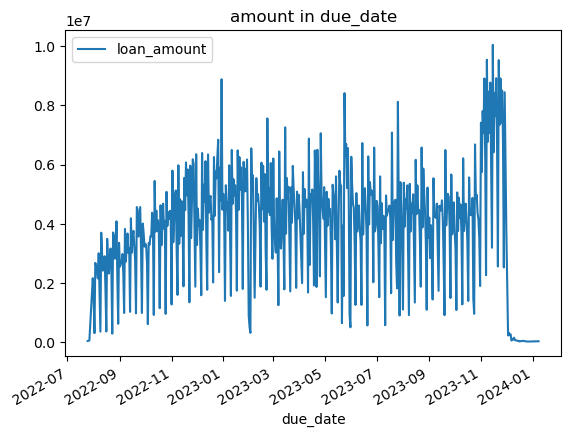

In [121]:
loan_amount = pd.pivot_table(df_loan,
                               index='due_date',
                               values='loan_amount',
                               aggfunc=np.sum).plot(title='amount in due_date')

## payment data

In [27]:
df_payment.head()

,loan_id,payment_date,paid_principal,paid_fines,paid_other
0,317618,2022-04-12,7970.0,0.0,0.0
1,430054,2023-06-27,40000.0,0.0,100.0
2,393860,2023-01-23,27030.0,0.0,0.0
3,339431,2022-06-08,50000.0,0.0,0.0
4,422007,2023-05-24,15000.0,0.0,100.0


In [28]:
df_payment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102716 entries, 0 to 102715
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   loan_id         102716 non-null  int64  
 1   payment_date    102716 non-null  object 
 2   paid_principal  102716 non-null  float64
 3   paid_fines      102716 non-null  float64
 4   paid_other      102716 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 3.9+ MB


In [29]:
df_payment['payment_date'] = pd.to_datetime(df_payment['payment_date'], format='%Y-%m-%d')

In [123]:
# let's look at the distribution of data on principal payments

In [31]:
payment_pivot = pd.pivot_table(df_payment,
                               index='payment_date',
                               values='paid_principal',
                               aggfunc=np.sum)

payment_pivot.sort_index(inplace=True)

payment_pivot_plot = payment_pivot.copy()
payment_pivot_decomp = payment_pivot.copy()

In [32]:
payment_pivot['rolling_mean_7'] = payment_pivot['paid_principal'].rolling(7).mean()
payment_pivot['rolling_mean_30'] = payment_pivot['paid_principal'].rolling(30).mean()

<Axes: xlabel='payment_date'>

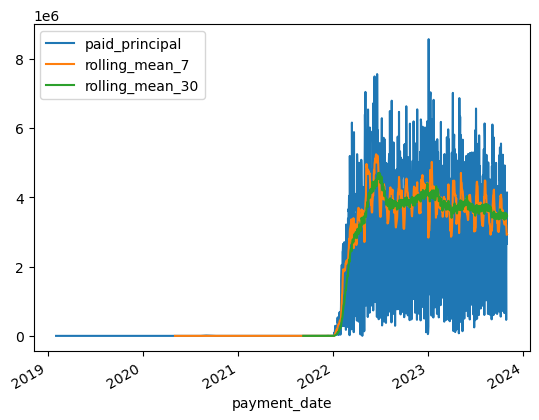

In [33]:
payment_pivot.plot()

<Axes: title={'center': 'sample 1D'}, xlabel='payment_date'>

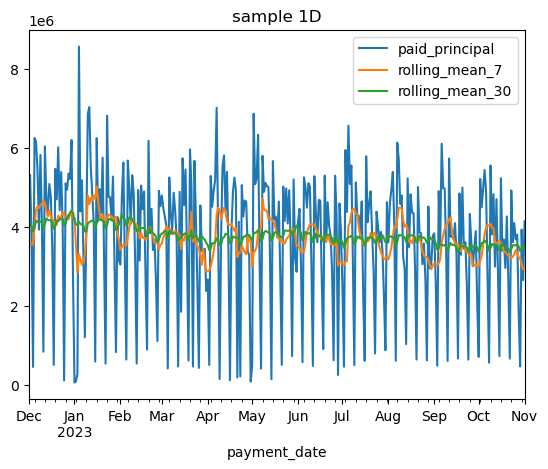

In [34]:
payment_pivot['2022-12-01':'2023-12-31'].plot(title='sample 1D')

In [124]:
# Let's look at the decomposition of seasonality, trend and noise

In [36]:
payment_pivot_d= payment_pivot_decomp.resample('1D').sum()
payment_pivot_m = payment_pivot_decomp.resample('1M').sum()

In [37]:
decomposed_d = seasonal_decompose(payment_pivot_d['2023-06-01':'2023-09-30'])

Text(0.5, 1.0, 'Seasonality')

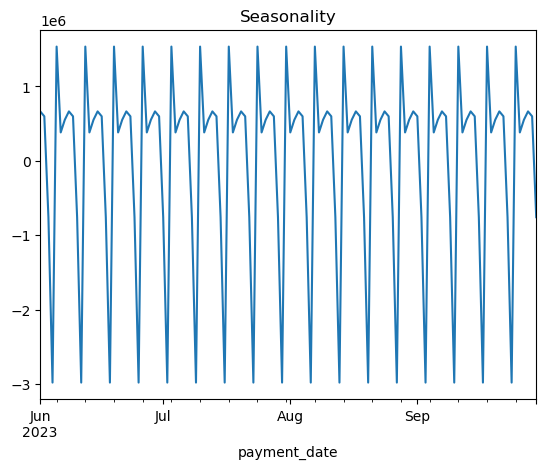

In [38]:
decomposed_d.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')

Text(0.5, 1.0, 'Trend')

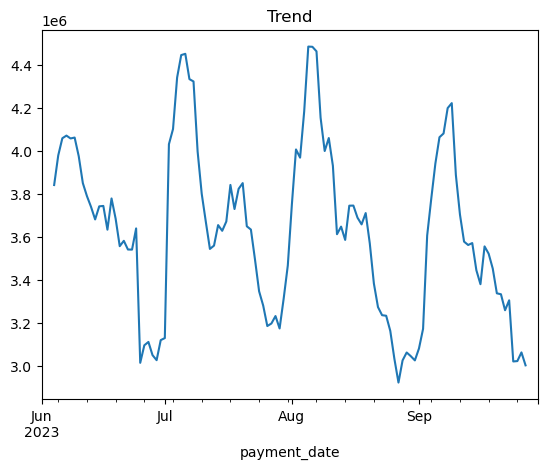

In [39]:
decomposed_d.trend.plot(ax=plt.gca())
plt.title('Trend')

Text(0.5, 1.0, 'Noise')

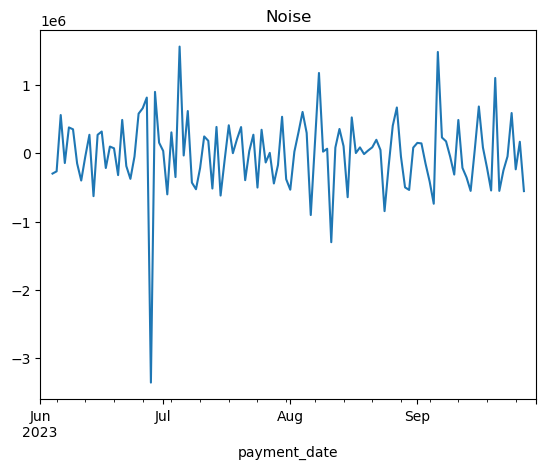

In [125]:
decomposed_d.resid.plot(ax=plt.gca())
plt.title('Noise')

# Conclusion

1. Client_data
    - There are a small number of gaps in the data
    - The data contains a client with monthly_salary exceeding 10 times (an obvious outlier)
    
2.Loan_data
    - The data contains gaps in the scoring_score field
    - In the data there are 4 clients that do not meet the criterion of having one short contract (duration <= 1 month)
    - Some clients have non-calendar and non-30 day installations
    
3. Payment_data
    - Data up to 2022-01-01 looks uneven, actually no data or test data
    - You can see by seasonality
        - main payments arrive on Monday, apparently due to the closure of write-offs on weekends
        - minimum receipts on weekends
        - it is also clear that the main payments come in the first half of the month, also with a peak in the third week

# creating a general calculation view

load the data into the Payment_data table data from Loan_data

The matrix can be unloaded using a sql script

In [41]:
df = df_payment.merge(df_loan, how='left', on='loan_id')

In [126]:
# look at the intersection of tables

In [43]:
print('share of contracts missing in the df_loan table - ',(1 - df_payment.loc[df_payment['loan_id'].isin(df_loan['loan_id'].unique().tolist())]['loan_id'].nunique()/df_payment['loan_id'].nunique())*100)

доля котрактов отсутсвующих в таблице df_loan -  31.818419265527865


In [127]:
print('share of contracts missing in the df_payment table - ',(1 - df_loan.loc[df_loan['loan_id'].isin(df_payment['loan_id'].unique().tolist())]['loan_id'].nunique()/df_loan['loan_id'].nunique())*100)

share of contracts missing in the df_payment table -  15.410165427178013


- 31.8% of unique loan_ids and unique ones in the loan table are missing in the payment table
- 15.4% of unique loan_id and unique ones in the payment table are missing in the loan table

The lack of data in the payment table can be explained as no payments were made under these contracts.

In [45]:
df_main = df_loan

******************

In [128]:
## calculate the payment amounts

In [47]:
df['paid_before_due'] = np.where(df['payment_date']<=df['due_date'], df['paid_principal'], 0)
df['recovery_total'] = np.where(df['payment_date']>df['due_date'], df['paid_principal'], 0)

df['recovery_01_15'] = np.where((df['payment_date']<(df['due_date']+ pd.DateOffset(days=15))) & (df['payment_date']>=(df['due_date']+ pd.DateOffset(days=1))), df['paid_principal'], 0)
df['recovery_15_30'] = np.where((df['payment_date']<(df['due_date']+ pd.DateOffset(days=30))) & (df['payment_date']>=(df['due_date']+ pd.DateOffset(days=15))), df['paid_principal'], 0)
df['recovery_30_45'] = np.where((df['payment_date']<(df['due_date']+ pd.DateOffset(days=45))) & (df['payment_date']>=(df['due_date']+ pd.DateOffset(days=30))), df['paid_principal'], 0)
df['recovery_45_60'] = np.where((df['payment_date']<(df['due_date']+ pd.DateOffset(days=60))) & (df['payment_date']>=(df['due_date']+ pd.DateOffset(days=45))), df['paid_principal'], 0)
#df['recovery_60_90'] = np.where((df['payment_date']<(df['due_date']+ pd.DateOffset(days=90))) & (df['payment_date']>=(df['due_date']+ pd.DateOffset(days=90))), df['paid_principal'], 0)

In [48]:
table_tmp = pd.pivot_table(df.loc[df['due_date']<=datetime.strptime('2023-11-01', '%Y-%m-%d')],
               index='loan_id',
               values=['paid_before_due','recovery_total','recovery_01_15','recovery_15_30','recovery_30_45','recovery_45_60'#,'recovery_60_90'
                      ],
               aggfunc=np.sum,
               fill_value=0).reset_index()

df_main = df_main.merge(table_tmp, on='loan_id', how='left')

In [50]:
for col in ['paid_before_due','recovery_total','recovery_01_15','recovery_15_30','recovery_30_45','recovery_45_60'
            #,'recovery_60_90'
           ]:
    df_main[col] = df_main[col].fillna(0)

In [51]:
# overdue_amount
# dpd

In [52]:
df_main['overdue_amount_01_15'] = df_main['loan_amount'] - df_main['paid_before_due']
df_main['overdue_amount_15_30'] = df_main['overdue_amount_01_15'] - df_main['recovery_01_15']
df_main['overdue_amount_30_45'] = df_main['overdue_amount_15_30'] - df_main['recovery_15_30']
df_main['overdue_amount_45_60'] = df_main['overdue_amount_30_45'] - df_main['recovery_30_45']
#df_main['overdue_amount_60_90'] = df_main['overdue_amount_45_60'] - df_main['recovery_45_60']
df_main['overdue_amount'] = df_main['loan_amount'] - df_main['paid_before_due']- df_main['recovery_total']

In [53]:
df_main['dpd_01_15'] = np.where(df_main['overdue_amount_01_15']>0, 1,0)
df_main['dpd_15_30'] = np.where(df_main['overdue_amount_15_30']>0, 1,0)
df_main['dpd_30_45'] = np.where(df_main['overdue_amount_30_45']>0, 1,0)
df_main['dpd_45_60'] = np.where(df_main['overdue_amount_45_60']>0, 1,0)
#df_main['dpd_60_90'] = np.where(df_main['overdue_amount_60_90']>0, 1,0)

df_main['cnt'] = 1

In [54]:
df_main['month_due'] = df_main['due_date'].dt.to_period('M')

In [55]:
# df_main.loc[df_main['recovery_30_45']>0].head()

In [59]:
df_task = pd.pivot_table(df_main,
               index='month_due',
               values=['loan_amount','recovery_01_15','recovery_15_30','recovery_30_45','recovery_45_60'
                       #,'recovery_60_90'
                       ,'overdue_amount_01_15','overdue_amount_15_30','overdue_amount_30_45','overdue_amount_45_60'
                       #,'overdue_amount_60_90'
                       ,'dpd_01_15','dpd_15_30','dpd_30_45','dpd_45_60'
                      # ,'dpd_60_90'
                       ,'cnt'],
               aggfunc=np.sum).reset_index()

In [100]:
df_task['share_dpd_01_15'] = df_task['dpd_01_15']/df_task['cnt']*100
df_task['share_dpd_15_30'] = df_task['dpd_15_30']/df_task['cnt']*100
df_task['share_dpd_30_45'] = df_task['dpd_30_45']/df_task['cnt']*100
df_task['share_dpd_45_60'] = df_task['dpd_45_60']/df_task['cnt']*100

df_task['share_overdue_01_15'] = df_task['overdue_amount_01_15']/df_task['loan_amount']*100
df_task['share_overdue_15_30'] = df_task['overdue_amount_15_30']/df_task['loan_amount']*100
df_task['share_overdue_30_45'] = df_task['overdue_amount_30_45']/df_task['loan_amount']*100
df_task['share_overdue_45_60'] = df_task['overdue_amount_45_60']/df_task['loan_amount']*100

df_task['share_recovery_01_15'] = df_task['recovery_01_15']/df_task['overdue_amount_01_15']*100
df_task['share_recovery_15_30'] = df_task['recovery_15_30']/df_task['overdue_amount_15_30']*100
df_task['share_recovery_30_45'] = df_task['recovery_30_45']/df_task['overdue_amount_30_45']*100
df_task['share_recovery_45_60'] = df_task['recovery_45_60']/df_task['overdue_amount_45_60']*100

# Recovery matrix

In [105]:
df_task.loc[df_task['month_due']<'2023-11'][['month_due','cnt','share_dpd_01_15','share_dpd_15_30','share_dpd_30_45','share_dpd_45_60',
         'share_overdue_01_15','share_overdue_15_30','share_overdue_30_45','share_overdue_45_60',
         'share_recovery_01_15','share_recovery_15_30','share_recovery_30_45','share_recovery_45_60']]

,month_due,cnt,share_dpd_01_15,share_dpd_15_30,share_dpd_30_45,share_dpd_45_60,share_overdue_01_15,share_overdue_15_30,share_overdue_30_45,share_overdue_45_60,share_recovery_01_15,share_recovery_15_30,share_recovery_30_45,share_recovery_45_60
0,2022-07,81,34.567901,14.814815,14.814815,13.580247,35.719697,14.037433,14.037433,13.591800,60.701142,0.000000,3.174603,0.000000
1,2022-08,2400,22.333333,12.666667,12.208333,11.541667,22.326029,11.267926,10.803042,9.938441,49.530095,4.125728,8.003309,2.847632
2,2022-09,2934,25.903204,14.451261,13.871847,13.190184,24.618619,12.824433,12.265527,11.574518,47.907588,4.358130,5.633752,2.377048
3,2022-10,3520,25.767045,14.517045,13.636364,12.869318,24.414069,12.743697,11.867881,10.976522,47.801830,6.872539,7.510683,2.672644
4,2022-11,3942,26.661593,13.495687,12.506342,12.506342,24.356616,10.836857,9.909231,9.909231,55.507541,8.559922,0.000000,0.000000
5,2022-12,4282,26.973377,15.203176,14.292387,13.194769,24.346999,11.970958,11.066026,10.087074,50.831894,7.559399,8.846461,3.833634
6,2023-01,4219,33.064707,16.639014,15.501304,14.671723,30.644500,13.393730,12.250952,11.368179,56.293203,8.532182,7.205753,3.791734
7,2023-02,3479,30.813452,17.275079,16.039092,15.291751,28.204102,13.565819,12.500317,11.752511,51.901255,7.854315,5.982295,1.747803
8,2023-03,4081,29.674099,17.446704,16.148003,15.069836,28.204038,14.873119,13.357378,12.327599,47.265994,10.191146,7.709437,3.439116
9,2023-04,4062,30.994584,16.125062,14.746430,13.958641,29.874060,13.812962,12.447002,11.499726,53.762688,9.888974,7.610477,1.910568


<Axes: xlabel='month_due'>

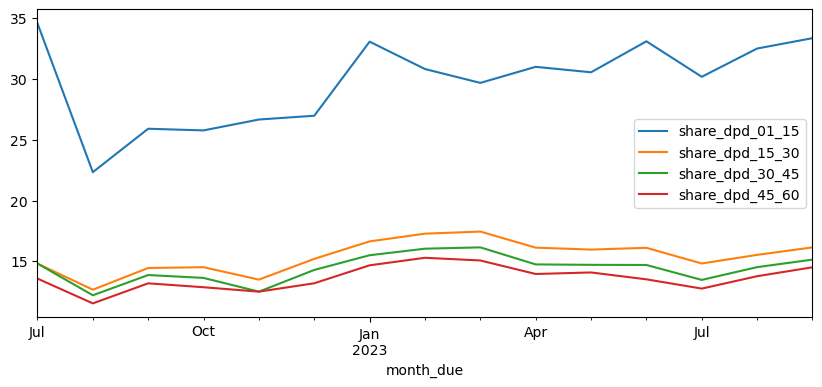

In [102]:
df_task.loc[df_task['month_due']<'2023-10'][['month_due','share_dpd_01_15','share_dpd_15_30','share_dpd_30_45','share_dpd_45_60']].plot(x = 'month_due', figsize=(10, 4))

<Axes: xlabel='month_due'>

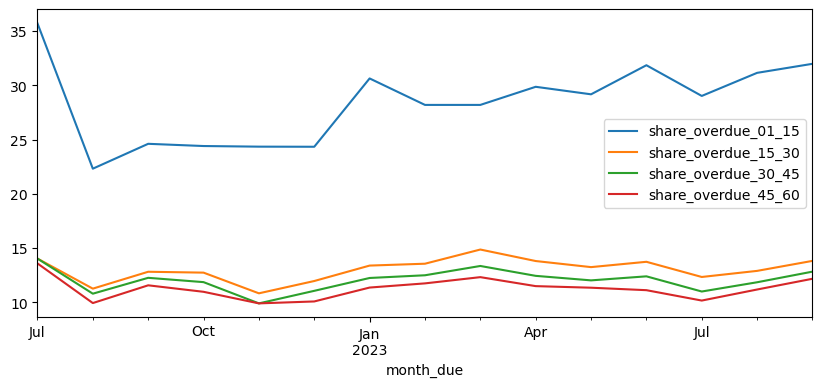

In [63]:
df_task.loc[df_task['month_due']<'2023-10'][['month_due','share_overdue_01_15','share_overdue_15_30','share_overdue_30_45','share_overdue_45_60']].plot(x = 'month_due', figsize=(10, 4))

<Axes: xlabel='month_due'>

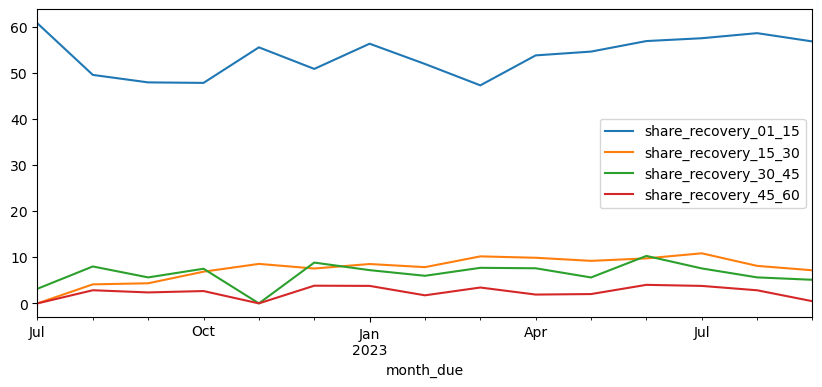

In [64]:
df_task.loc[df_task['month_due']<'2023-10'][['month_due','share_recovery_01_15','share_recovery_15_30','share_recovery_30_45','share_recovery_45_60']].plot(x = 'month_due', figsize=(10, 4))

<Axes: xlabel='month_due'>

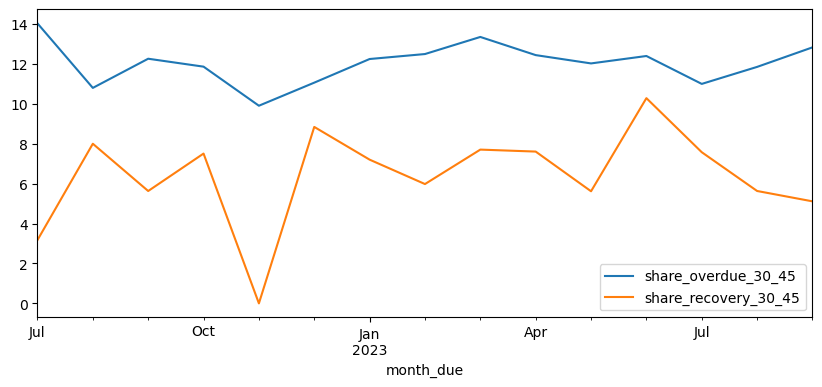

In [85]:
df_task.loc[df_task['month_due']<'2023-10'][['month_due','share_overdue_30_45','share_recovery_30_45']].plot(x = 'month_due', figsize=(10, 4))

In [84]:
cols = ['loan_amount',
         'overdue_amount_01_15',
         'overdue_amount_15_30',
         'overdue_amount_30_45',
         'overdue_amount_45_60',
         'recovery_01_15',
         'recovery_15_30',
         'recovery_30_45',
         'recovery_45_60']

df_task.loc[(df_task['month_due']>'2022-11') & ((df_task['month_due']<'2023-10'))][cols].corr()

,loan_amount,overdue_amount_01_15,overdue_amount_15_30,overdue_amount_30_45,overdue_amount_45_60,recovery_01_15,recovery_15_30,recovery_30_45,recovery_45_60
loan_amount,1.000000,0.374820,0.624657,0.640617,0.547918,0.101040,0.303166,0.647246,0.739236
overdue_amount_01_15,0.374820,1.000000,0.508231,0.497615,0.471696,0.888013,0.350490,0.339925,0.370951
overdue_amount_15_30,0.624657,0.508231,1.000000,0.985383,0.943609,0.055310,0.662042,0.639375,0.516777
overdue_amount_30_45,0.640617,0.497615,0.985383,1.000000,0.973648,0.050807,0.524689,0.592181,0.465411
overdue_amount_45_60,0.547918,0.471696,0.943609,0.973648,1.000000,0.043062,0.431874,0.392805,0.314914
recovery_01_15,0.101040,0.888013,0.055310,0.050807,0.043062,1.000000,0.052872,0.052725,0.154153
recovery_15_30,0.303166,0.350490,0.662042,0.524689,0.431874,0.052872,1.000000,0.589803,0.534878
recovery_30_45,0.647246,0.339925,0.639375,0.592181,0.392805,0.052725,0.589803,1.000000,0.764026
recovery_45_60,0.739236,0.370951,0.516777,0.465411,0.314914,0.154153,0.534878,0.764026,1.000000


# Customer segmentation

In [108]:
df_main = df_main.merge(df_client, on = 'client_id', how='left')

In [109]:
def hist_compare(df1, df2, column, bins):
    ax = df1.plot(kind = 'hist',
                 y = column,
                 bins = bins,
                 alpha = 0.3,
                 grid = True,
                 legend = True,           
                 label = 'debt',
                 figsize = (8, 4.5))
    df2.plot(kind = 'hist',
                  y = column,
                  ax = ax,               
                  bins = bins,
                  alpha = 0.4,
                  grid = True,
                  legend = True,
                  label = 'cur')

In [110]:
cols = ['dpd_30_45',
        'loan_amount',
         'scoring_score',
         'duration',         
         'monthly_salary',
         'age']

data = df_main[cols]

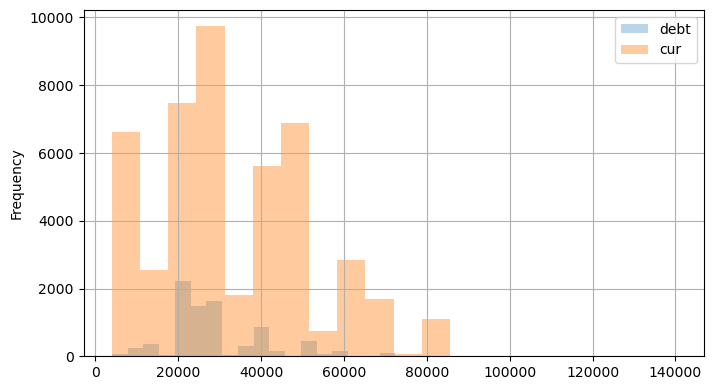

In [111]:
hist_compare(df_main.loc[(df_main['dpd_30_45']==1) & (df_main['month_due']<'2023-11')], 
             df_main.loc[(df_main['dpd_30_45']==0) & (df_main['month_due']<'2023-11')] , 'loan_amount', bins=20)

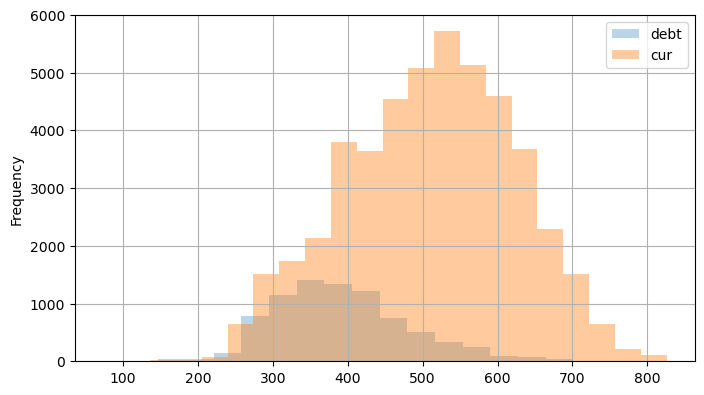

In [112]:
hist_compare(df_main.loc[(df_main['dpd_30_45']==1) & (df_main['month_due']<'2023-11')], 
             df_main.loc[(df_main['dpd_30_45']==0) & (df_main['month_due']<'2023-11')]  , 'scoring_score', bins=20)

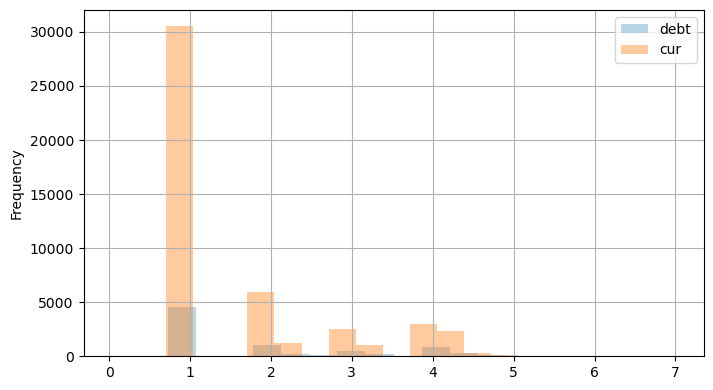

In [113]:
hist_compare(df_main.loc[(df_main['dpd_30_45']==1) & (df_main['month_due']<'2023-11')], 
             df_main.loc[(df_main['dpd_30_45']==0) & (df_main['month_due']<'2023-11')]  , 'duration', bins=20)

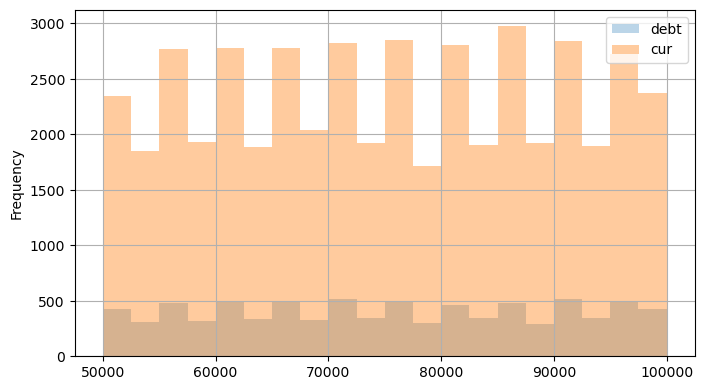

In [114]:
hist_compare(df_main.loc[(df_main['dpd_30_45']==1) & (df_main['month_due']<'2023-11')], 
             df_main.loc[(df_main['dpd_30_45']==0) & (df_main['month_due']<'2023-11')]  , 'monthly_salary', bins=20)

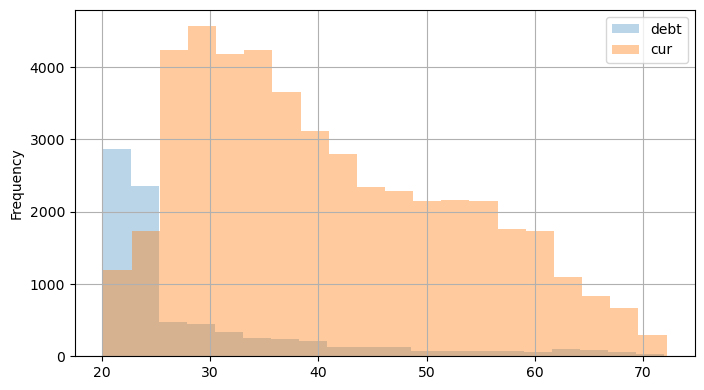

In [115]:
hist_compare(df_main.loc[(df_main['dpd_30_45']==1) & (df_main['month_due']<'2023-11')], 
             df_main.loc[(df_main['dpd_30_45']==0) & (df_main['month_due']<'2023-11')]  , 'age', bins=20)

In [116]:
table_tmp = pd.pivot_table(df_main.loc[df_main['month_due']<'2023-11'],
                           index='month_due',
                           values=['age','scoring_score'],
                           aggfunc=np.mean)

<Axes: xlabel='month_due'>

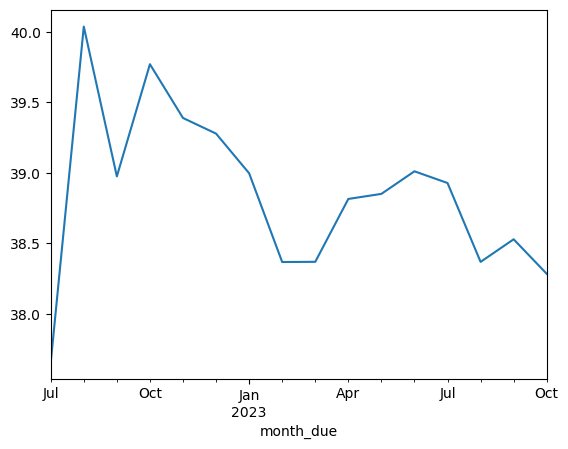

In [117]:
table_tmp['age'].plot()

<Axes: xlabel='month_due'>

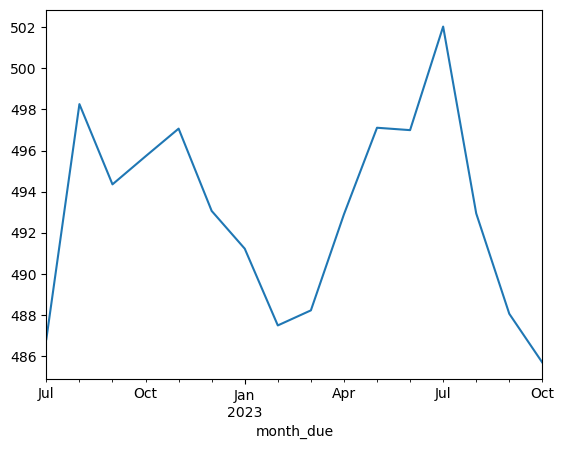

In [118]:
table_tmp['scoring_score'].plot()

# Conclusion

1. There is a deterioration in the issuance segment, there is an increase in overdue of the first payment from January 2023, as well as an increase of 30+dpd (cnt - 14.7% and amount - 19.1%) from May 2023.
2. we see a deterioration in the indicators of recent periods; in September there was a high level of overdue clients and the lowest level of recovery rate for the year
3. we see anomalies for clients with due_date November 2022, there are no payments for clients with 30+dpd and above

Main clients subject to delinquency
- score_bal 300-400
- age from 20-25 years

# Search for anomalies

In [ ]:
df_main['start_dateY'] = df_main['start_date'].dt.year
df_main['start_dateM'] = df_main['start_date'].dt.month
df_main['start_dateD'] = df_main['start_date'].dt.day

df_main['due_dateY'] = df_main['due_date'].dt.year
df_main['due_dateM'] = df_main['due_date'].dt.month
df_main['due_dateD'] = df_main['due_date'].dt.day

# df_main.drop(['start_date','due_date','birthday','month_due','loan_id','client_id','cnt','fl_debt','loan_status'], axis=1)

In [ ]:
df_main = df_main.loc[~df_main['scoring_score'].isnull()]
df_main = df_main.loc[~df_main['monthly_salary'].isnull()]
df_main = df_main.loc[~df_main['age'].isnull()]

In [ ]:
data = df_main.loc[df_main['month_due']<'2023-11'].drop(['start_date','due_date','birthday','month_due','loan_id','client_id','cnt','fl_debt','loan_status'], axis=1)

In [ ]:
knn = KNN()
knn.fit(data) 
estimation_knn = knn.fit_predict(data)

isolation_forest = IsolationForest(n_estimators=100, random_state=7575)
estimator_iforest = isolation_forest.fit_predict(data) 

data['outliers_knn'] = estimation_knn
data['outliers_isolationfores'] = estimator_iforest

df_main.loc[df_main['month_due']<'2023-11']['outliers_total'] = np.where((data['outliers_knn']==1) & (data['outliers_isolationfores']==-1), 1, 0)

In [ ]:
df_main.loc[df_main['outliers_total']==1].head()

# Conclusion

Using the isolation forest model and the nearest neighbors method, ~7% of anomalies were found in the ensemble; the data in the dataframe is indicated by flag 1 (outliers_total field)

# Results

1. Data analysis
    - Client_data
        - there are a small number of gaps in the data
        - The data contains a client with monthly_salary exceeding 10 times (hard outlier)
    - Loan_data
        - The data contains gaps in the scoring_score field
        - In the data there are 4 clients that do not meet the criterion of having one short contract (duration <= 1 month)
        - Some clients have non-calendar and non-30 day installations
    - Payment_data
        - from 2019-01-01 to 2022-01-01 non-presentable data, presumably test data
        - we see anomalies for clients with due_date November 2022, there are no payments for clients with 30+dpd and above        
    - General observations
        - 31.8% of unique loan_ids and those present in Loan_data are missing in the Payment_data table (you need to look at the filling logic)
        - 15.4% of unique loan_ids and those present in Payment_data are missing from the Loan_data table (inexplicable, obvious error)
        - Using the isolation forest model and the nearest neighbors method in the ensemble shows ~7% anomalies in the data, detailed analysis is required
2. Metric analysis
    - The share of clients (of the entire portfolio) has dpd30+ 14.7% with a peak value of 19.1%
    - The share of overdue payments (from the entire portfolio) has dpd30+ 12.2% with a peak value of 16.8%
    - There is a trend of increasing overdue
    - In October 2023, we observed a deterioration in recovery; with overdue increasing to 16.8%, we have a minimum recovery rate of 5.11% (7.1% on average) 
3. Offers
    - DC
        - Segment clients for work, the data shows that clients are susceptible to overdue of dpd30+
            - clients aged 20-25 years
            - scoring_score 300-420
        - If calls are not made on weekends, generate additional mailings(sms, chats). Most payments arrive early in the week
        - Increase staff, projected workload increase from December 2023
        - It is necessary to check the MS and spin rate. Presumably, the increase in overdue was not blocked in October 2023
    -Data
        - It is necessary to do additional control of incoming data